# Importing Required Libraries

In [2]:
import os
import cv2
import pandas as pd
import tensorflow as tf
import seaborn as sns
from keras.utils import np_utils
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model

# Importing Dataset

In [3]:
raw_data_csv_file_name = 'data/fer2013.csv'
raw_data = pd.read_csv(raw_data_csv_file_name)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [4]:
raw_data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
raw_data["Usage"].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

# Viewing images in Dataset

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def show_image_and_label(x, y):
    x_reshaped = x.reshape(48,48)
    plt.imshow(x_reshaped, cmap= "gray",
              interpolation="nearest")
    plt.axis("off")
    plt.show()
    print(y)

# x_pixels
img = raw_data["pixels"][0]
val = img.split(" ")
x_pixels = np.array(val, 'float32')
x_pixels /= 255
np.shape(x_pixels)

(2304,)

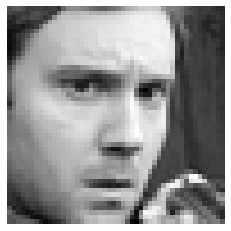

0


In [13]:
show_image_and_label(x_pixels, raw_data["emotion"][0])

(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)

# Required Functions For Preprocessing of Dataset

In [22]:
TRAIN_END = 28708
TEST_START = TRAIN_END + 1
NUM_CLASSES = 7
IMG_SIZE = 48

def split_for_test(list):
    train = list[0:TRAIN_END]
    test = list[TEST_START:]
    return train, test

def pandas_vector_to_list(pandas_df):
    py_list = [item[0] for item in pandas_df.values.tolist()]
    return py_list

def process_emotion(emotion):
    """
    Takes in a vector of emotions and outputs a list of emotions as one-hot vectors.
    :param emotion: vector of ints (0-7)
    :return: list of one-hot vectors (array of 7)
    """
    emotion_as_list = pandas_vector_to_list(emotion)
    y_data = []
    for index in range(len(emotion_as_list)):
        y_data.append(emotion_as_list[index])

    # Y data
    y_data_categorical = np_utils.to_categorical(y_data, NUM_CLASSES)
    return y_data_categorical

def process_pixels(pixels, img_size=48):
    """
    Takes in a string (pixels) that has space separated ints. Will transform the ints
    to a 48x48 matrix of floats(/255).
    :param pixels: string with space separated ints
    :param img_size: image size
    :return: array of 48x48 matrices
    """
    pixels_as_list = pandas_vector_to_list(pixels)

    np_image_array = []
    for index, item in enumerate(pixels_as_list):
        # 48x48
        data = np.zeros((img_size, img_size), dtype=np.uint8)
        # split space separated ints
        pixel_data = item.split()

        # 0 -> 47, loop through the rows
        for i in range(0, img_size):
            # (0 = 0), (1 = 47), (2 = 94), ...
            pixel_index = i * img_size
            # (0 = [0:47]), (1 = [47: 94]), (2 = [94, 141]), ...
            data[i] = pixel_data[pixel_index:pixel_index + img_size]

        np_image_array.append(np.array(data))

    np_image_array = np.array(np_image_array)
    # convert to float and divide by 255
    np_image_array = np_image_array.astype('float32') / 255.0
    return np_image_array

def duplicate_input_layer(array_input, size):
    vg_input = np.empty([size, 48, 48, 3])
    for index, item in enumerate(vg_input):
        item[:, :, 0] = array_input[index]
        item[:, :, 1] = array_input[index]
        item[:, :, 2] = array_input[index]
    return vg_input

# Pre-Processing Dataset

In [23]:
# convert to one hot vectors
emotion_array = process_emotion(raw_data[['emotion']])
# convert to a 48x48 float matrix
pixel_array = process_pixels(raw_data[['pixels']])

# Splitting Train-Test Data

In [24]:
# split for test/train
y_train, y_test = split_for_test(emotion_array)
x_train_matrix, x_test_matrix = split_for_test(pixel_array)
n_train = int(len(x_train_matrix))
n_test = int(len(x_test_matrix))

In [25]:
x_train_input = duplicate_input_layer(x_train_matrix, n_train)
x_test_input = duplicate_input_layer(x_test_matrix, n_test)

# Defining Model

In [19]:
#Get back the convolutional part of a VGG network trained on ImageNet
model_vgg16_conv = VGG16(weights='imagenet', include_top=False,)
model_vgg16_conv.summary()

inp = Input(shape=(48, 48, 3),name = 'image_input')

#Use the generated model 
output_vgg16_conv = model_vgg16_conv(inp)

#Add the fully-connected layers 
x = Flatten(name='flatten')(output_vgg16_conv)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(7, activation='softmax', name='predictions')(x)

#Create your own model 
my_model = Model(inp,x)

#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
my_model.summary()

58892288/58889256 [==============================] - 16s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_____________________________________________________________

In [23]:
np.shape(x_train_input)

(28708, 48, 48, 3)

### Optimizer for Model and Compiling Model

In [24]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.01)
my_model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Creating Checkpoint Callback for Training

In [28]:
checkpoint_path = "current_training/checkpoint/cp-{epoch:04d}.ckpt"
#checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

### Training Model

In [ ]:
my_model.fit(x_train_input, y_train,
          epochs=80,
          batch_size=32,
          validation_data=(x_test_input, y_test),
          callbacks=[cp_callback])

# Saving Trained Model

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
my_model.save('saved_model/my_model')

### Loading Pre-trained Model with Weights included

In [27]:
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()

# Restore the weights
#new_model.load_weights('cp-0074.ckpt')

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)      

# Evaluating Accuracy on Training Data

In [127]:
# Evaluate the restored model
loss, acc = new_model.evaluate(x_train_input,  y_train, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

print(new_model.predict(x_train_input).shape)

898/898 - 197s - loss: 0.0041 - accuracy: 0.9979
Restored model, accuracy: 99.79%
(28708, 7)


# Evaluating Accuracy on Test Data

In [28]:
# Evaluate the restored model
loss, acc = new_model.evaluate(x_test_input,  y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

print(new_model.predict(x_test_input).shape)

225/225 - 42s - loss: 3.0060 - accuracy: 0.6775
Restored model, accuracy: 67.75%
(7178, 7)


## Predict from a single image

#### EMOTION_DICT = {1:"ANGRY", 2:"DISGUST", 3:"FEAR", 4:"HAPPY", 5:"SAD", 6:"SURPRISE", 7:"NEUTRAL"}

In [31]:
import cv2
path = 'fear2.jpg'
img = cv2.imread(path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2.imwrite(path, gray)
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml') 
img = cv2.imread(path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
for (x,y,w,h) in faces:
    face_clip = img[y:y+h, x:x+w]
    cv2.imwrite(path, cv2.resize(face_clip, (48, 48)))
read_image = cv2.imread(path)
read_image = read_image.reshape(1, read_image.shape[0], read_image.shape[1], read_image.shape[2])
read_image_final = read_image/255.0
top_pred = new_model.predict(read_image_final)
emotion_label = top_pred[0].argmax() + 1
emotion_label

3